**CNN**

In [2]:
import zipfile
import os
import urllib.request

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
filename = "pizza_steak.zip"

if not os.path.exists(filename):
    print("Se descarca datele...")
    urllib.request.urlretrieve(url, filename)
    print("Descărcare completa.")
else:
    print("Fișierul exista deja.")

with zipfile.ZipFile("file","r") as zip_ref:
    zip_ref.extractall()
#zipfile.ZipExtFile(filename)
#print("Se dezarhiveaza...")
#zip_ref = zipfile.ZipFile(filename, "r")
#zip_ref.extractall()
#zip_ref.close()

Se descarcă datele...
Descărcare completă.
Se dezarhivează...
Gata!


In [5]:
import zipfile
import os
import urllib.request
num_steak_nr=len(os.listdir("./pizza_steak/train/steak"))
print(f"There are {num_steak_nr} numbers of images ")

for path,dir,file in os.walk("pizza_steak"):
    print(f"There are {len(dir)} directories and {len(file)} images in {path}")

There are 750 numbers of images 
There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak\test
There are 0 directories and 250 images in pizza_steak\test\pizza
There are 0 directories and 250 images in pizza_steak\test\steak
There are 2 directories and 0 images in pizza_steak\train
There are 0 directories and 750 images in pizza_steak\train\pizza
There are 0 directories and 750 images in pizza_steak\train\steak


In [6]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,sub_directory,target_class):
    folder=target_dir+"/"+sub_directory+"/"+target_class
    
    #random_image=random.sample(os.listdir(folder),1)
    #img=mpimg.imread(folder+"/"+random_image[0]) // random_image[0]->pt ca returneaza o lista de imagini chiar daca e o singura imagine pentru am specificat mai sus 1
    
    random_image=random.choice(os.listdir(folder))
    img=mpimg.imread(folder+"/"+random_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis(False)
    print(f"Image shape: {img.shape}")
    return img

Image shape: (307, 512, 3)


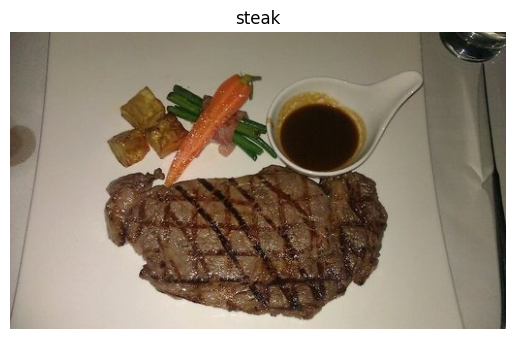

In [7]:
image=view_random_image("pizza_steak","train","steak")

In [8]:
image

array([[[ 83,  80,  73],
        [ 84,  81,  74],
        [ 86,  82,  73],
        ...,
        [ 73,  74,  66],
        [ 37,  39,  34],
        [ 22,  24,  19]],

       [[ 82,  79,  72],
        [ 83,  80,  73],
        [ 85,  81,  72],
        ...,
        [ 39,  40,  32],
        [ 45,  46,  40],
        [ 38,  41,  34]],

       [[ 85,  80,  74],
        [ 86,  81,  75],
        [ 87,  83,  74],
        ...,
        [ 34,  32,  20],
        [ 34,  34,  24],
        [ 30,  32,  21]],

       ...,

       [[144, 134, 125],
        [145, 135, 126],
        [149, 139, 130],
        ...,
        [ 46,  47,  42],
        [ 43,  43,  43],
        [ 65,  65,  65]],

       [[145, 135, 126],
        [145, 135, 126],
        [149, 139, 130],
        ...,
        [ 50,  49,  45],
        [ 56,  56,  56],
        [ 92,  92,  92]],

       [[147, 137, 128],
        [146, 136, 127],
        [149, 139, 130],
        ...,
        [ 49,  48,  44],
        [ 56,  56,  56],
        [106, 106, 106]]

In [9]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_data_generator=ImageDataGenerator(rescale=1./255)
test_data_generator=ImageDataGenerator(rescale=1./255)

train_path="pizza_steak/train/"
test_path="pizza_steak/test/"

train_data=train_data_generator.flow_from_directory(train_path,
                                                    batch_size=32,
                                                    target_size=(224,224),
                                                    class_mode="binary",
                                                    seed=42)

test_data=test_data_generator.flow_from_directory(test_path,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  class_mode='binary',
                                                  seed=42)

model_1=tf.keras.Sequential([
    tf.keras.layers.Conv2D( filters=10, # 10 filtre de detectie diferite 
                            kernel_size=3,#(3,3) mini batches 
                            activation='relu',
                            input_shape=[224,224,3]),
    tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,# imi ia un patrat de 2,2 si imi ia valoarea maxima 
                          padding='valid' # daca imaginea nu se imparte exact la 2,2 imi ginora marginile  
                          ), 
    tf.keras.layers.Conv2D(filters=10,
                           activation='relu',
                           kernel_size=3),
    tf.keras.layers.Conv2D(filters=10,
                           activation='relu', # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
                           kernel_size=3),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid') # activation for binary 
])

model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_1=model_1.fit(train_data,epochs=5,steps_per_epoch=len(train_data),
                      validation_data=test_data,validation_steps=len(test_data))   

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


C:\Users\darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.6967 - loss: 0.5741 - val_accuracy: 0.8360 - val_loss: 0.3990
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8020 - loss: 0.4425 - val_accuracy: 0.8500 - val_loss: 0.3518
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8220 - loss: 0.4082 - val_accuracy: 0.8740 - val_loss: 0.3543
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.8380 - loss: 0.3660 - val_accuracy: 0.8580 - val_loss: 0.3474
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.8393 - loss: 0.3758 - val_accuracy: 0.8620 - val_loss: 0.3392


We can do the evaluation when we fit the model 
**1.model_1.fit(validation_data=test_data,validation_step=len(test_data)**
**2.model_1.evaluate(test_data)**   

In [11]:
model_1.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8620 - loss: 0.3392


[0.33922943472862244, 0.8619999885559082]

In [12]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)